# Lung Cancer Binary Classifier Model
- Andrew E. Davidson
- [aedavids@ucsc.edu](mailto:aedavids@edu?subject=lungCancerBinaryClassifier.ipynb)
- ?? what is the attribution for the kim lab

Use logistic regression to classify lung vs. 'not lung' from gene expression

## Overview
* lung cancer vs. normal classifier using logistic regression
* model is save to disk $rootDir/models/logisticRegressionLungNotLung.h5
* training set comprised of gene expression values from Xena data set. The data was randomly split into 80/20 train/test sets
* surprisingly all example appear to be from people that are sick. Examples labeled as as normal does not imply the person was healthy. Notice figure 1 does not have a "health class". It might be very useful to create a data set that contains both health and sick people
* model summary
    ```
    total data set size 19,126 example each with 58,581 features

AEDWIP !!!!!! wrong stats
    training set accuracy = 0.9994
        test set accuracy = 0.9929

    confusion matrix
    [[1701   19]
     [   8 2098]]
    False positive rate: (predicting tumor while normal) 0.011
    False negative rate: (predicting normal while tumor) 0.004
    ```
    
TODO: explore example that are not classified correctly
    
see 
- [lungCancerClassifierExploration.ipynb](lungCancerClassifierExploration.ipynb)
- [lungCancerClassifierEvaluation.ipynb](lungCancerClassifierEvaluation.ipynb)


In [1]:
import pathlib as pl

import logging
from   setupLogging import setupLogging
configFilePath = setupLogging( default_path=pl.Path('../src/logging.ini.json'))
configFilePath = setupLogging( default_path=pl.Path('../src/logging.test.ini.json'))
logger = logging.getLogger("notebook")
logger.info("using logging configuration file:{}".format(configFilePath))

from dataUtilities.lungCancerData import LungCancerData

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras import layers
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Input

from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

# fix random seed for reproducibility
theMeaningOfLife = 42
np.random.seed(theMeaningOfLife)

[INFO <ipython-input-1-cb04d083fd9c>:8 - <module>()] using logging configuration file:../src/logging.test.ini.json


# Load Data


In [5]:
%%time
dataDir = pl.Path("../data")
TCGADataFile = pl.Path("tcga_target_gtex.h5".format(dataDir))
lcData = LungCancerData(dataDir, TCGADataFile)
lcData.loadTrainingData(theMeaningOfLife)
lcData.loadTestData(theMeaningOfLife)

[INFO lungCancerData.py:257 - loadTrainingData()] BEGIN
[INFO lungCancerData.py:265 - loadTrainingData()] store.info():<class 'pandas.io.pytables.HDFStore'>
File path: ../data/lungCancerData/machineLeaning.h5
/XTestDF                 frame        (shape->[3826,58581]) 
/XTrainDF                frame        (shape->[15300,58581])
/yTestSeries             series       (shape->[3826])       
/yTrainSeries            series       (shape->[15300])      
[INFO lungCancerData.py:266 - loadTrainingData()] store.keys():['/XTestDF', '/XTrainDF', '/yTestSeries', '/yTrainSeries']
[INFO lungCancerData.py:272 - loadTrainingData()] (15300, 58581)
[INFO lungCancerData.py:273 - loadTrainingData()] (15300,)
[INFO lungCancerData.py:278 - loadTrainingData()] END
[INFO lungCancerData.py:286 - loadTestData()] BEGIN
[INFO lungCancerData.py:294 - loadTestData()] store.info():<class 'pandas.io.pytables.HDFStore'>
File path: ../data/lungCancerData/machineLeaning.h5
/XTestDF                 frame        (shape->

In [6]:
print(lcData.XTrainNP.shape)
print(lcData.yTrainSeries.values.shape)
print()
print(lcData.XTestNP.shape)
print(lcData.yTestSeries.values.shape)

(15300, 58581)
(15300,)

(3826, 58581)
(3826,)


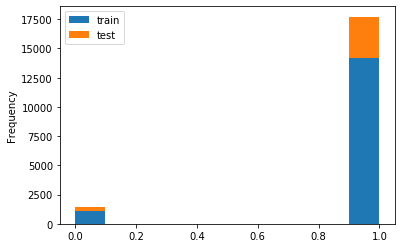

In [7]:
# checking if class balance is maintained
# AEDWIP do these graphs make sence?
labels = {'train': (lcData.yTrainSeries), 'test': (lcData.yTestSeries)}
label_df = pd.DataFrame(labels)
label_df.plot.hist(stacked=True)

## Train Classifier

In [8]:
# this is a neural network with a single activation node
def logisticRegression(input_dim=None, output_dim=None, lr=0.001):
    '''
    implement a neural network with a single activation node. Uses a
    Adam optimizer with the binary_crossentropy function
    
    Includes a batch normalization preprocess step. normalizaton 
    typically reduces training time.
    
    arguments:
        input_dim:
           type int: the number of features in each sample
        
        outputDim: 
            type int the number of classes
        
        lr: 
            type float: scaling factor for adjusting weight. larger
            values may train faster how ever can cause optimization 
            algorithm to diverge if to large. Use loss curver plot
            to evaluate    
    
    return:
        keras.models
    '''
    classify = [
        Input(shape=(input_dim, )),

        # TODO: Is Keras smart? only need to run preprocessing step
        # once
        BatchNormalization(),
        Dense(output_dim),  # dot(input, kernel) + bias
        Activation('sigmoid')
    ]

    model = Sequential(classify)

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy'])

    return model

In [9]:
%%time
modelName = "logisticRegressionCancerNotCancer"
logisticRegressionModel = logisticRegression(
    input_dim=lcData.XTrainNP.shape[1], output_dim=1)

# https://keras.io/callbacks/
checkPointPath = "./models/{}.chkPt".format(modelName)
callbacks = [
    # monitor valuse either 'acc' for accuracy or 'loss'
    # 'val_loss' is loss on hold if valaidation_split is set
    # 'loss' is loss on training
    # same for 'acc' and 'val_acc'
    EarlyStopping(monitor='loss', patience=2, verbose=0),
    ModelCheckpoint(
        checkPointPath, monitor='loss', save_best_only=False, verbose=0)
    # FIXME: progbar generates run time error
    #,ProgbarLogger(count_mode='samples', stateful_metrics=None)
]

history = logisticRegressionModel.fit(
    lcData.XTrainNP,
    lcData.yTrainSeries.values,
    shuffle=None,  # we already shuffled
    epochs=20,  #100
    batch_size=1024,
    # we already split the data
    validation_split=0.0,
    verbose=1,
    callbacks=callbacks)

Train on 15300 samples
Epoch 1/20
14336/15300 [===========================>..] - ETA: 1s - loss: 0.7783 - accuracy: 0.7692[WARNING deprecation.py:506 - new_func()] From /Users/andrewdavidson/anaconda3/envs/findBiomarkers/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[INFO builder_impl.py:775 - copy_assets_to_destination_dir()] Assets written to: ./models/logisticRegressionCancerNotCancer.chkPt/assets
15300/15300 [==============================] - 24s 2ms/sample - loss: 0.7359 - accuracy: 0.7820
Epoch 2/20
15300/15300 [==============================] - 9s 587us/sample - loss: 0.0339 - accuracy: 0.9897
Epoch 3/20
15300/15300 [==============================] - 7s 439us/sample - loss: 0.0095 - accuracy: 0.9969
Epo

In [10]:
logisticRegressionModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 58581)             234324    
_________________________________________________________________
dense (Dense)                (None, 1)                 58582     
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 292,906
Trainable params: 175,744
Non-trainable params: 117,162
_________________________________________________________________


In [11]:
%%time
# evaluate() computes the loss based on the input you pass
# predict() generates output predictions based on the input you pass it
evalTrain = logisticRegressionModel.evaluate(lcData.XTrainNP, lcData.yTrainSeries.values, verbose=0)
evalTest  = logisticRegressionModel.evaluate(lcData.XTestNP,  lcData.yTestSeries.values,  verbose=0)

print("AEDWIP look at last training lost loss: 0.0068 - accuracy: 0.9999")

print("train")
print("Loss    : {:.4f}".format(evalTrain[0]))
print("Accuracy: {:.4f}".format(evalTrain[1]))

print("\ntest")
print("Loss    : {:.4f}".format(evalTest[0]))
print("Accuracy: {:.4f}".format(evalTest[1]))

AEDWIP look at last training lost loss: 0.0068 - accuracy: 0.9999
train
Loss    : 70.4687
Accuracy: 0.0737

test
Loss    : 70.5374
Accuracy: 0.0737
CPU times: user 35.5 s, sys: 1min 26s, total: 2min 1s
Wall time: 56.4 s


In [19]:
from sklearn.metrics import confusion_matrix

yTestPredict = logisticRegressionModel.predict(lcData.XTestNP)
print(yTestPredict[0:3])
yTestPredict = [1 if p > 0.5 else 0 for p in yTestPredict]
print(yTestPredict[0:3])

# lcData.yTrainSeries.values
yTest = lcData.yTestSeries.values
print(confusion_matrix(yTest, yTestPredict))


# confusion matrix  C is such that C_i,j  is equal to the number of observations 
# known to be in group i  and predicted to be in group j.
tn, fp, fn, tp = confusion_matrix(yTest, yTestPredict).ravel()
fpr = fp * 1.0 / (fp + tn)
fnr = fn * 1.0 / (tp + fn)
print("False positive rate: (predicting tumor while normal)", fpr)
print("False negative rate: (predicting normal while tumor)", fnr)

[[7.836662e-34]
 [2.584138e-27]
 [0.000000e+00]]
[0, 0, 0]
[[ 282    0]
 [3544    0]]
False positive rate: (predicting tumor while normal) 0.0
False negative rate: (predicting normal while tumor) 1.0


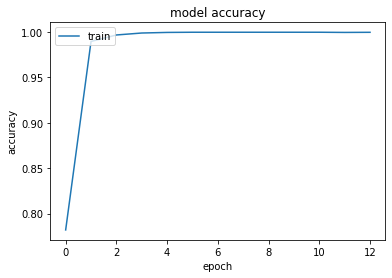

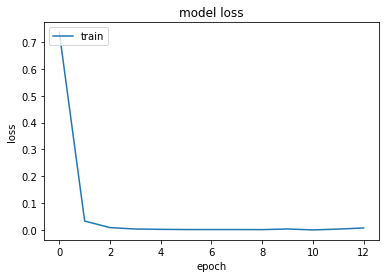

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# # summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
# import os
# AEDWIP: FIXME: switch to PathLib it is OS independent
modelRootDir = pl.Path("../models")
fullModelPath = pl.Path("{}/{}.h5".format(modelRootDir, modelName))

# if not os.path.exists(modelRootDir):
if not modelRootDir.exists():
    print("create modle directory:{}".format(modelRootDir))
    #os.makedirs(modelRootDir)
    modelRootDir.mkdir()

# if not os.path.isfile(fullModelPath):
if not fullModelPath.exists():
    logisticRegressionModel.save(fullModelPath)
    print("Saved {} to disk".format(fullModelPath))
else:
    print("ERROR: model was not save. files already exist {}".format(
        fullModelPath))

create modle directory:../models
Saved ../models/logisticRegressionCancerNotCancer.h5 to disk


In [ ]:
!pwd
!ls -l $fullModelPath